In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the data

In [2]:
parent_path=os.path.join(os.getcwd(), os.pardir)
file_path=os.path.join(parent_path, "raw_data/train.csv")
data=pd.read_csv(file_path).copy()
data.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [3]:
texts=data["full_text"]
text_scores=data.drop(columns=["text_id", "full_text"])
train_texts, val_texts, train_targets, val_targets=train_test_split(texts, text_scores, test_size=0.3)

<Axes: xlabel='size', ylabel='Count'>

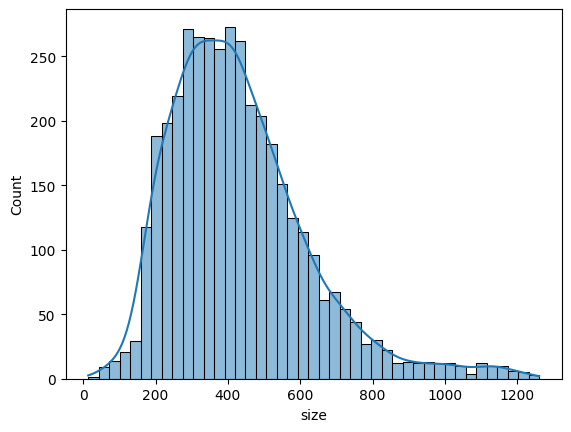

In [4]:
data["size"]=data["full_text"].apply(lambda x : len(x.split()))
sns.histplot(data["size"], kde=True)

In [5]:
data["size"].max()

1260

# Defining the loss function

In [6]:
def loss_func(y_true, y_pred):
    losses=[]
    for column in y_true.columns:
        res=np.sqrt(sum((y_true[column]-y_pred[column])**2)/len(y_true))
        losses.append(res)
    return np.mean(losses)

# Embedding with Word2vec

### Preprocessing texts with keras built-in text preprocessing tool

In [7]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

X_train = [text_to_word_sequence(_) for _ in list(train_texts)]
X_val = [text_to_word_sequence(_) for _ in list(val_texts)]


2023-03-07 17:03:32.128997: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 17:03:33.301412: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-07 17:03:33.301494: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-07 17:03:33.443299: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-07 17:03:36.207995: W tensorflow/stream_executor/platform/de

### Embedding with Word2vec

In [8]:
# YOUR CODE HERE
from gensim.models import Word2Vec

word2vec = Word2Vec(sentences=X_train)
wv = word2vec.wv

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

# Embed the training and test sentences
X_train_embed = embedding(word2vec, X_train)
X_val_embed = embedding(word2vec, X_val)


# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=1260)
X_val_pad = pad_sequences(X_val_embed, dtype='float32', padding='post', maxlen=1260)

In [10]:
X_train_pad.shape

(2737, 1260, 100)

In [11]:
for X in [X_train_pad]:
    assert type(X) == np.ndarray
    assert X.shape[-1] == word2vec.wv.vector_size


assert X_train_pad.shape[0] == len(X_train)

# The model

is an RNN with the following layers:
- a `Masking` layer
- a `LSTM` with 20 units and `tanh` activation function
- a `Dense` with 10 units
- an output layer with 6 neurons

In [12]:
#from tensorflow.keras import layers, Input, Sequential
#from keras import backend as K
#def build_model():
#    model = Sequential()
#
#    model.add(layers.Masking(mask_value=0.0, input_shape=(1260,100))
#    # Built-in masking layer :)
#    )
#    model.add(layers.LSTM(20))
#    model.add(layers.Dense(10, activation="relu"))
#    
#    model.add(layers.Dense(6, activation="linear"))
#    return model
#
#model = build_model()
#
#def root_mean_squared_error(y_true, y_pred):
#        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
#
#model.compile(loss='mse',
#              optimizer='adam',
#              metrics=root_mean_squared_error)

In [13]:
#model.summary()

In [14]:
#np.array(train_targets).shape

In [15]:
#from tensorflow.keras import callbacks

#es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
#model.fit(X_train_pad,
          #train_targets,
          #validation_split=0.2,
          #batch_size=56,
          #epochs=300,
          #verbose=1,
          #callbacks=[es])


In [16]:
from tensorflow.keras import layers, Input, Sequential, Model
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
    
def initiate_model():
    main_input = Input((1260,100))
    masking_layer = layers.Masking(mask_value=0.0, input_shape=(1260,100))(main_input)
    lstm_layer=layers.LSTM(20)(masking_layer)
    dense_layer = layers.Dense(10, activation="relu")(lstm_layer)
    
    #parallele layers : 1 layer for each output (score)
    outputs=['cohesion_output', 'syntax_output', 'vocabulary_output', 'phraseology_output', 'grammar_output', 'conventions_output']
    cohesion_output=layers.Dense(1, activation="linear", name="cohesion")(dense_layer)
    syntax_output=layers.Dense(1, activation="linear", name="syntax")(dense_layer)
    vocabulary_output=layers.Dense(1, activation="linear", name="vocabulary")(dense_layer)
    phraseology_output=layers.Dense(1, activation="linear", name="phraseology")(dense_layer)
    grammar_output=layers.Dense(1, activation="linear", name="grammar")(dense_layer)
    conventions_output=layers.Dense(1, activation="linear", name="conventions")(dense_layer)
    
    # Assembling the model
    model = Model(main_input, [cohesion_output, syntax_output, vocabulary_output, phraseology_output, grammar_output, conventions_output])
    return model
model=initiate_model()


2023-03-07 17:03:50.572342: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-07 17:03:50.572919: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-07 17:03:50.572954: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-0OMFI0Q): /proc/driver/nvidia/version does not exist
2023-03-07 17:03:50.573277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
# compiling the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1260, 100)]  0           []                               
                                                                                                  
 masking (Masking)              (None, 1260, 100)    0           ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 20)           9680        ['masking[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 10)           210         ['lstm[0][0]']                   
                                                                                              

In [18]:
# compiling the model
model.compile(loss='mse', optimizer='adam', loss_weights=[1/6 for i in range(6)], metrics=root_mean_squared_error)

In [19]:
from tensorflow.keras import callbacks

es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_train_pad,
          train_targets,
          validation_split=0.2,
          batch_size=56,
          epochs=100,
          verbose=1,
          callbacks=[es])

2023-03-07 17:03:52.810062: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1103256000 exceeds 10% of free system memory.


Epoch 1/100
40/40 [==============================] - 48s 955ms/step - loss: 5.9512 - cohesion_loss: 8.1616 - syntax_loss: 3.7258 - vocabulary_loss: 3.2614 - phraseology_loss: 7.5783 - grammar_loss: 4.8291 - conventions_loss: 8.1512 - cohesion_root_mean_squared_error: 2.7499 - syntax_root_mean_squared_error: 1.6658 - vocabulary_root_mean_squared_error: 1.5590 - phraseology_root_mean_squared_error: 2.6516 - grammar_root_mean_squared_error: 1.9878 - conventions_root_mean_squared_error: 2.7881 - val_loss: 2.4732 - val_cohesion_loss: 2.6210 - val_syntax_loss: 0.8583 - val_vocabulary_loss: 0.7915 - val_phraseology_loss: 4.9554 - val_grammar_loss: 0.8233 - val_conventions_loss: 4.7899 - val_cohesion_root_mean_squared_error: 1.5072 - val_syntax_root_mean_squared_error: 0.8131 - val_vocabulary_root_mean_squared_error: 0.7840 - val_phraseology_root_mean_squared_error: 2.1385 - val_grammar_root_mean_squared_error: 0.7853 - val_conventions_root_mean_squared_error: 2.1141
Epoch 2/100
40/40 [=======

In [22]:
results=model.evaluate(X_val_pad, val_targets)

2023-03-07 17:42:26.083021: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 591696000 exceeds 10% of free system memory.


37/37 [==============================] - 8s 209ms/step - loss: 0.4511 - cohesion_loss: 0.4555 - syntax_loss: 0.4491 - vocabulary_loss: 0.4522 - phraseology_loss: 0.4562 - grammar_loss: 0.4461 - conventions_loss: 0.4473 - cohesion_root_mean_squared_error: 0.6087 - syntax_root_mean_squared_error: 0.6058 - vocabulary_root_mean_squared_error: 0.6090 - phraseology_root_mean_squared_error: 0.6093 - grammar_root_mean_squared_error: 0.6054 - conventions_root_mean_squared_error: 0.6049


In [31]:
MCRMSE=np.mean(results[7:])
MCRMSE

0.607193519671758

## Conclusion
We computed a baseline of 0.653, the LSTM model has improved the score of 0.046(decrease by 6%)